# PCA


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
print(tf.__version__)


2.19.0


In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images to be vectors of size 784
X_train_flat = X_train.reshape(-1, 784)

In [4]:
pca = PCA(n_components=784)
X_pca = pca.fit_transform(X_train_flat)

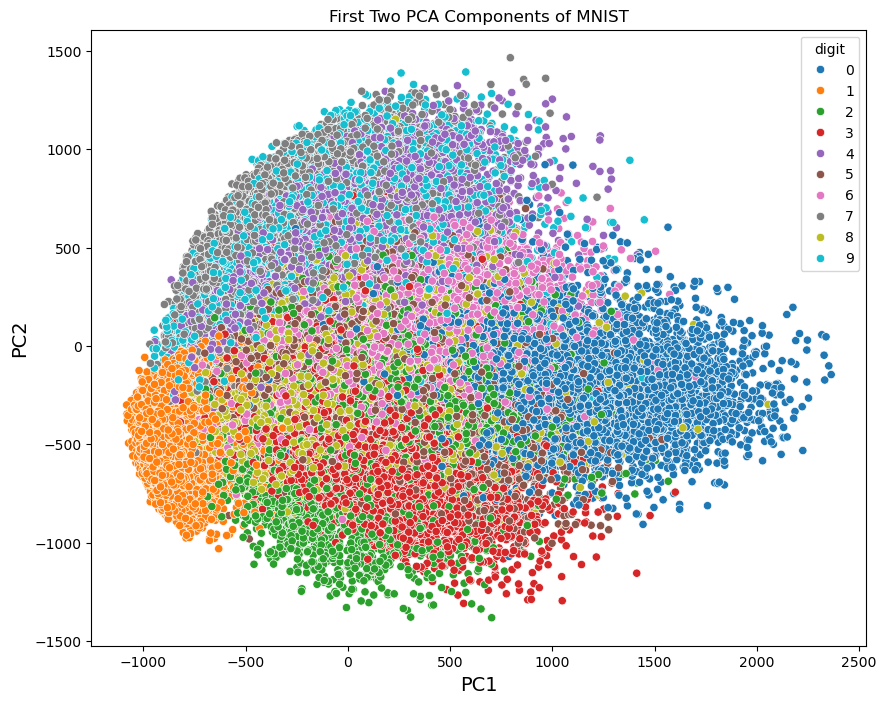

In [5]:
# Create a dataframe with the first two components for visualization
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['digit'] = y_train

# Plot the first two components with color coding for digits
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='digit', palette='tab10', data=pca_df, legend='full')
plt.title('First Two PCA Components of MNIST')
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.show()

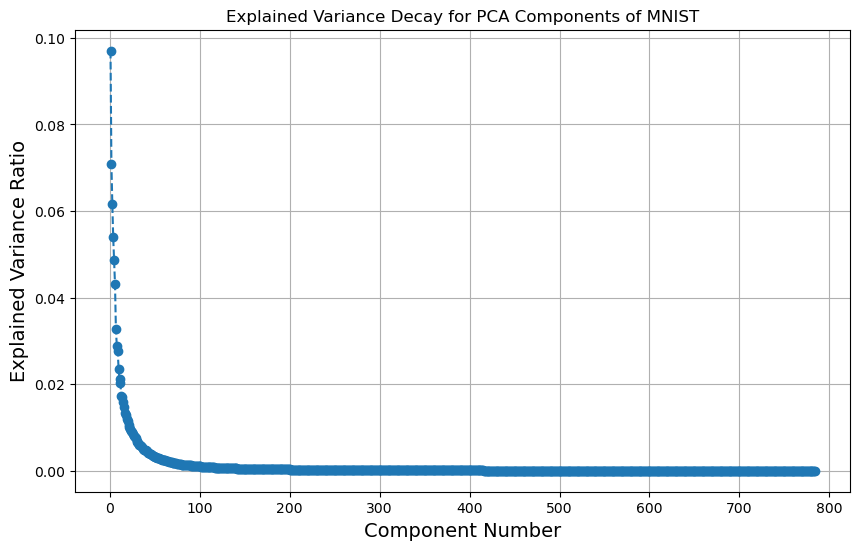

In [6]:
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance (standard deviation) decay
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 785), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance Decay for PCA Components of MNIST')
plt.xlabel('Component Number',fontsize=14)
plt.ylabel('Explained Variance Ratio',fontsize=14)
#plt.yscale('log')
#plt.ylim(1e-4,1)
plt.grid(True)
plt.show()


In [7]:
# Let's look at the reconstruction with varying number of components.

np.random.seed(42)
random_indices = np.random.choice(X_train_flat.shape[0], 5, replace=False)
selected_images = X_train_flat[random_indices]

components = [1, 2, 5, 10, 20, 50, 100, 200]

In [8]:
random_indices

array([12628, 37730, 39991,  8525,  8279])

In [9]:
j=2
pca_temp = PCA(n_components=components[j])
image_pca = pca_temp.fit_transform(X_train_flat)


In [10]:
image_pca

array([[ 123.93270304, -312.67055118,  -24.51934982, -555.77662822,
         -27.27040461],
       [1011.71852844, -294.85867623,  596.34074178, -460.76498928,
        -827.28409608],
       [ -51.84968402,  392.1724885 , -188.51462435,  521.00663385,
        -306.67052199],
       ...,
       [-178.05348211,  160.07885273, -257.61181895, -714.65002877,
        -210.3215466 ],
       [ 130.6064884 ,   -5.5977432 ,  513.86236396,  342.70853005,
        -521.18868575],
       [-173.43574154,  -24.71832482,  556.01404095, -120.87594324,
        -197.9843446 ]])

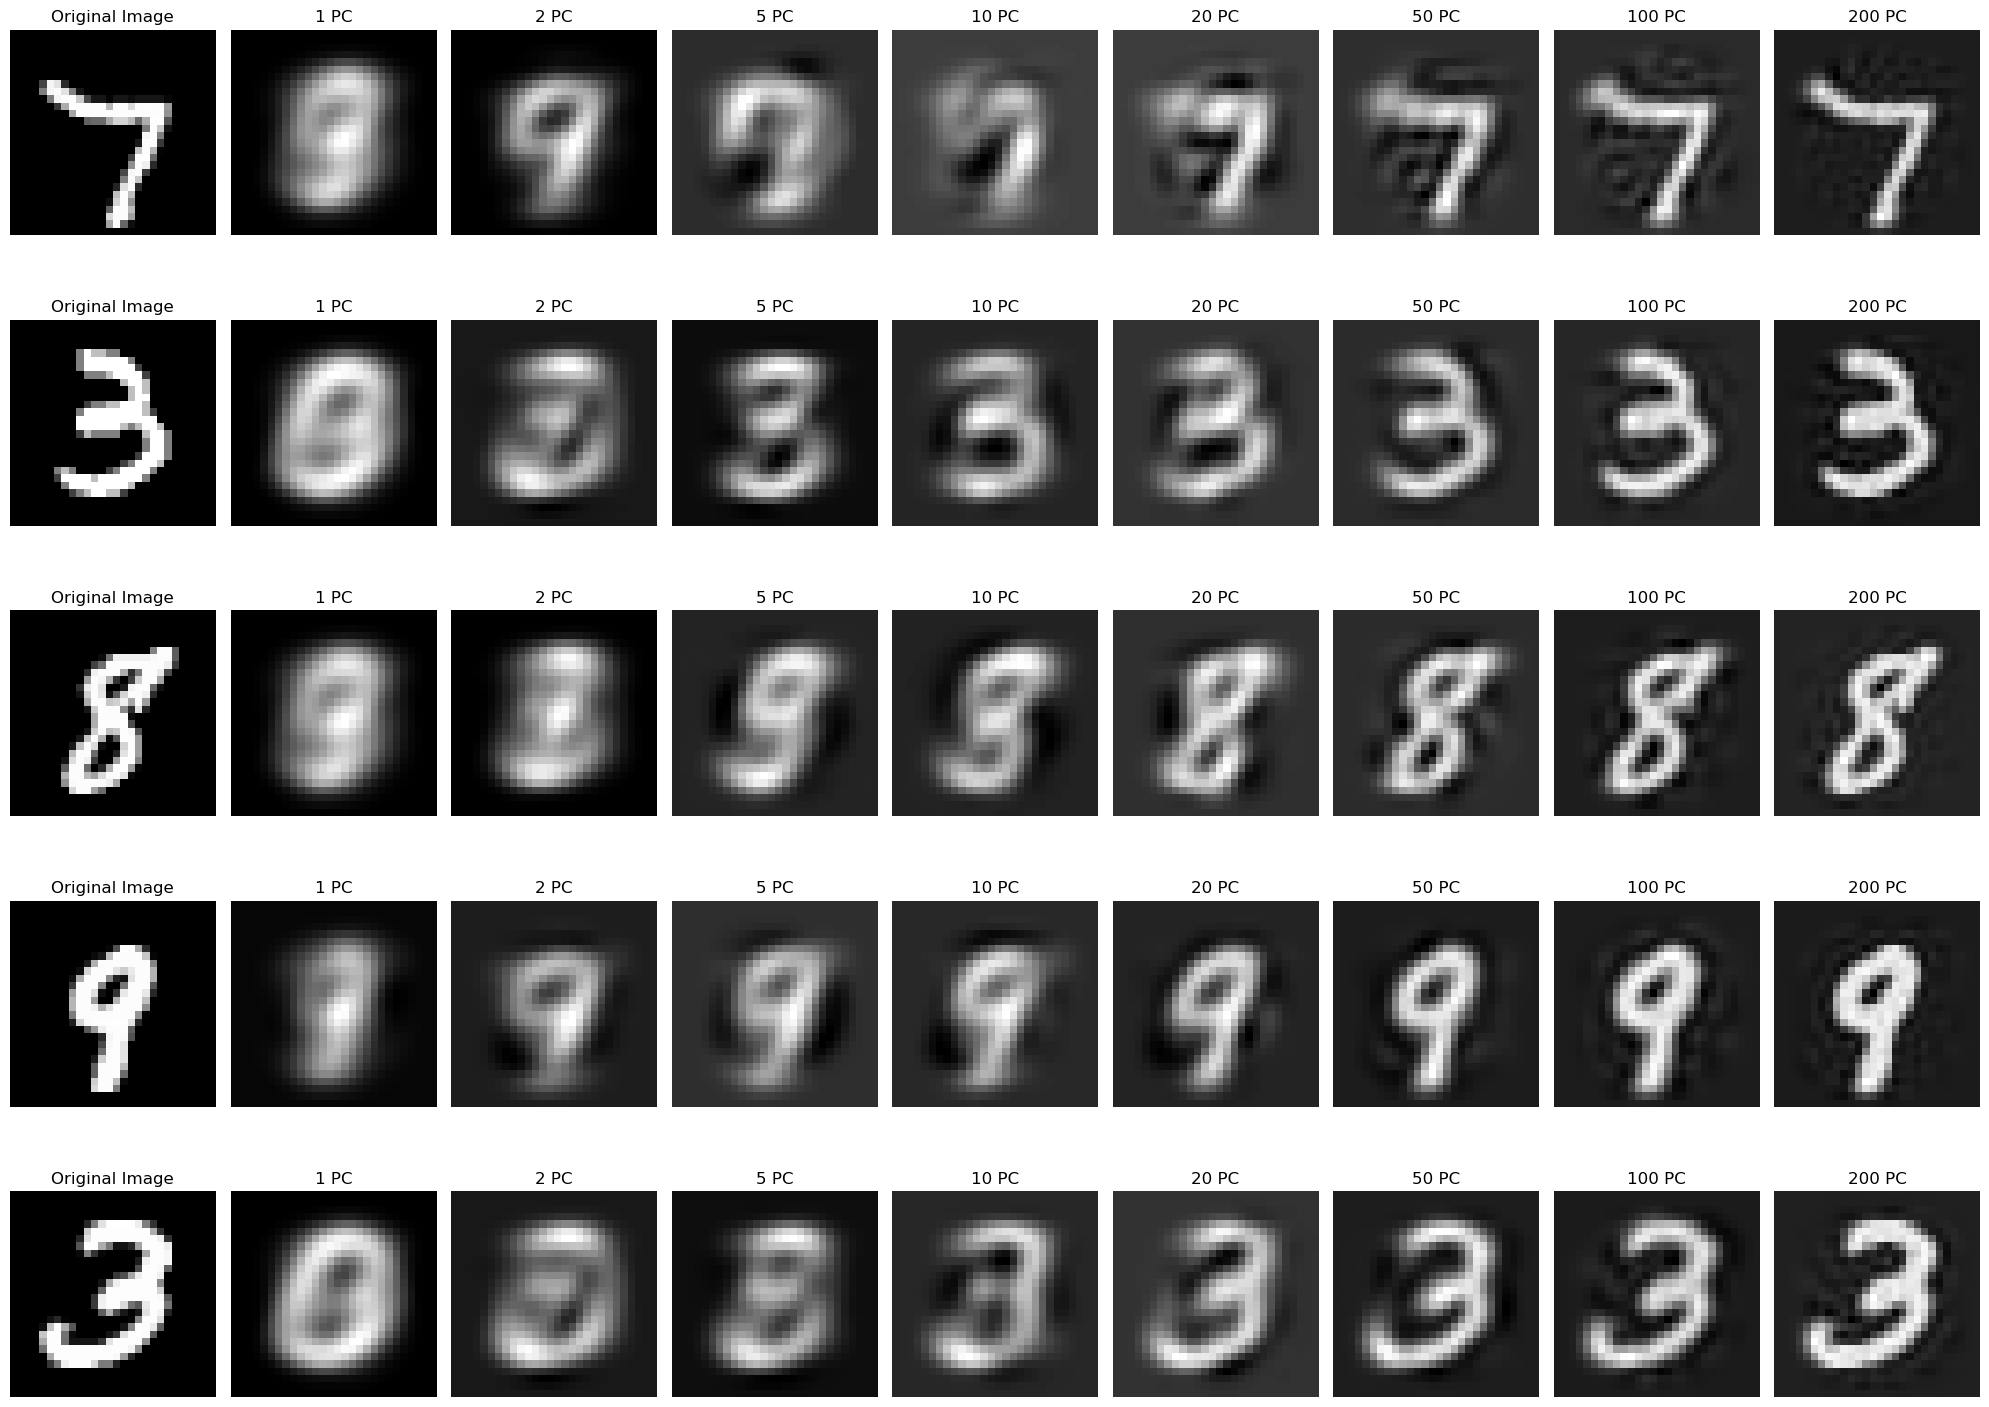

In [11]:
fig, axes = plt.subplots(5, len(components) + 1, figsize=(20, 15))

for i, image in enumerate(selected_images):
    axes[i, 0].imshow(image.reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')
    
    for j in range(len(components)):
        pca_temp = PCA(n_components=components[j])
        image_pca = pca_temp.fit_transform(X_train_flat)
        image_reconstructed = pca_temp.inverse_transform(image_pca[random_indices[i]])
        
        axes[i, j + 1].imshow(image_reconstructed.reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f'{components[j]} PC')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

# Autoencoder

We now perform an autoencoder for MNIST. 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

# For visualization
import seaborn as sns


In [13]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [14]:
# Define the input dimension (28*28 pixels = 784)
input_dim = x_train.shape[1]
latent_dim = 2  # Two-dimensional bottleneck

# Encoder
input_img = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(latent_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_img, decoded)

# Separate encoder model
encoder = Model(input_img, bottleneck)

# Define the decoder input
encoded_input = Input(shape=(latent_dim,))
decoder_layer1 = autoencoder.layers[-4](encoded_input)
decoder_layer2 = autoencoder.layers[-3](decoder_layer1)
decoder_layer3 = autoencoder.layers[-2](decoder_layer2)
decoder_output = autoencoder.layers[-1](decoder_layer3)

# Separate decoder model
decoder = Model(encoded_input, decoder_output)


In [15]:
# Compile the autoencoder
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1047 - val_loss: 0.0580
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0563 - val_loss: 0.0519
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0510 - val_loss: 0.0487
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0484 - val_loss: 0.0474
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0469 - val_loss: 0.0463
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0459 - val_loss: 0.0450
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0448 - val_loss: 0.0442
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0439 - val_loss: 0.0436
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0432 - val_loss: 0.0429
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0427 - val_loss: 0.0426
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0424 - val_loss: 0.0420
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

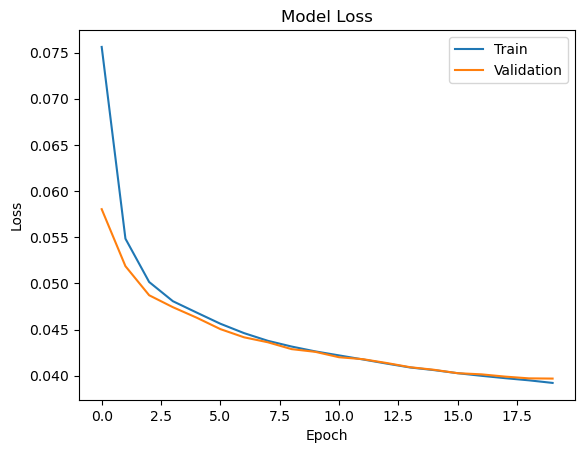

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


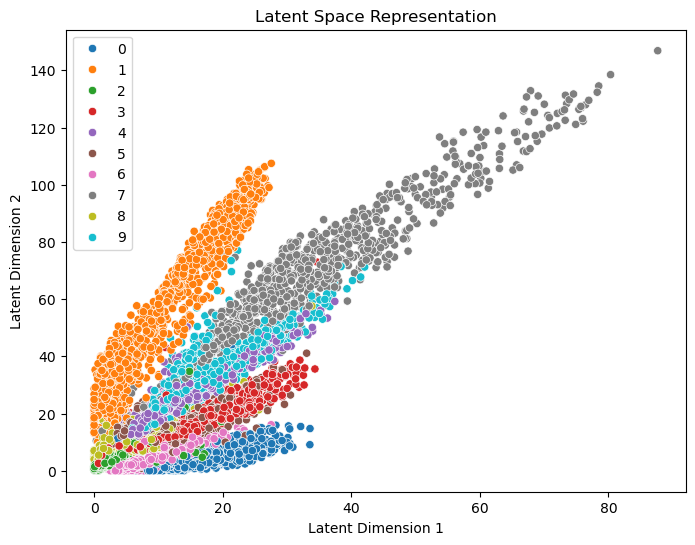

In [17]:
# Encode the test set to visualize the latent space
encoded_imgs = encoder.predict(x_test)

# Plotting the latent space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=encoded_imgs[:, 0], y=encoded_imgs[:, 1], hue=y_test, palette="tab10", legend='full')
plt.title('Latent Space Representation')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step


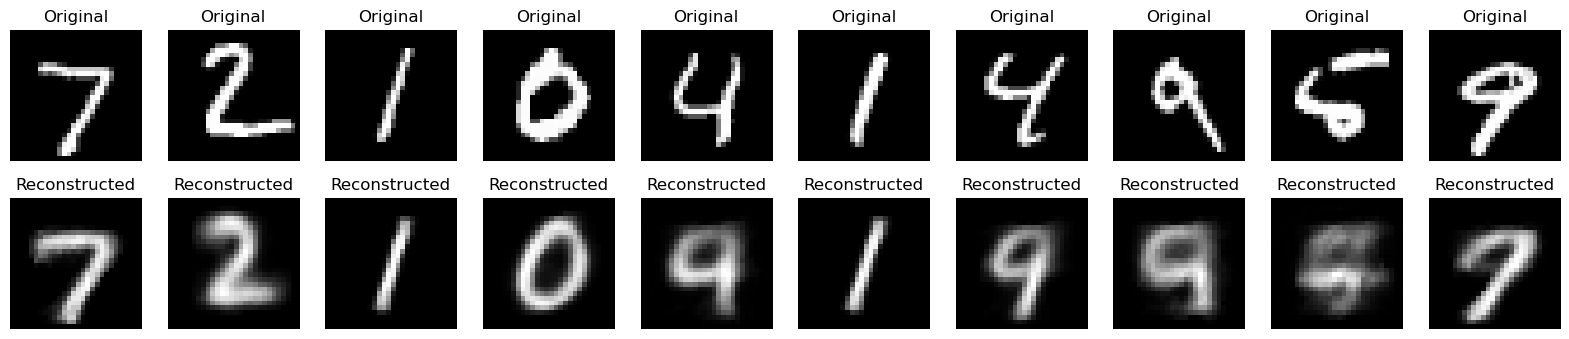

In [19]:
# Predict the reconstructed images from the test set
reconstructed_imgs = autoencoder.predict(x_test)

# Number of images to display
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [40]:
# improvement: more training, deeper network, cnn, regularisation for overfitting

# T-SNE

Apply t-SNE on MNIST. Vary the perplexity and compare the respective latent dimensions in two dimensions.

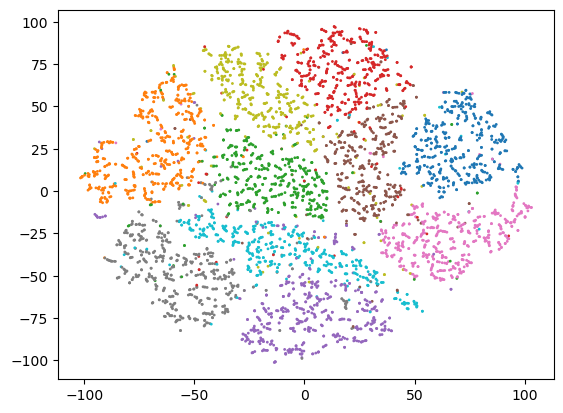

In [20]:
tsne = TSNE(n_components=2, perplexity=5, random_state=1)
X_embedded = tsne.fit_transform(X_train_flat[:5000])  # Use a subset for efficiency
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train[:5000].astype(int), cmap='tab10', s=1)

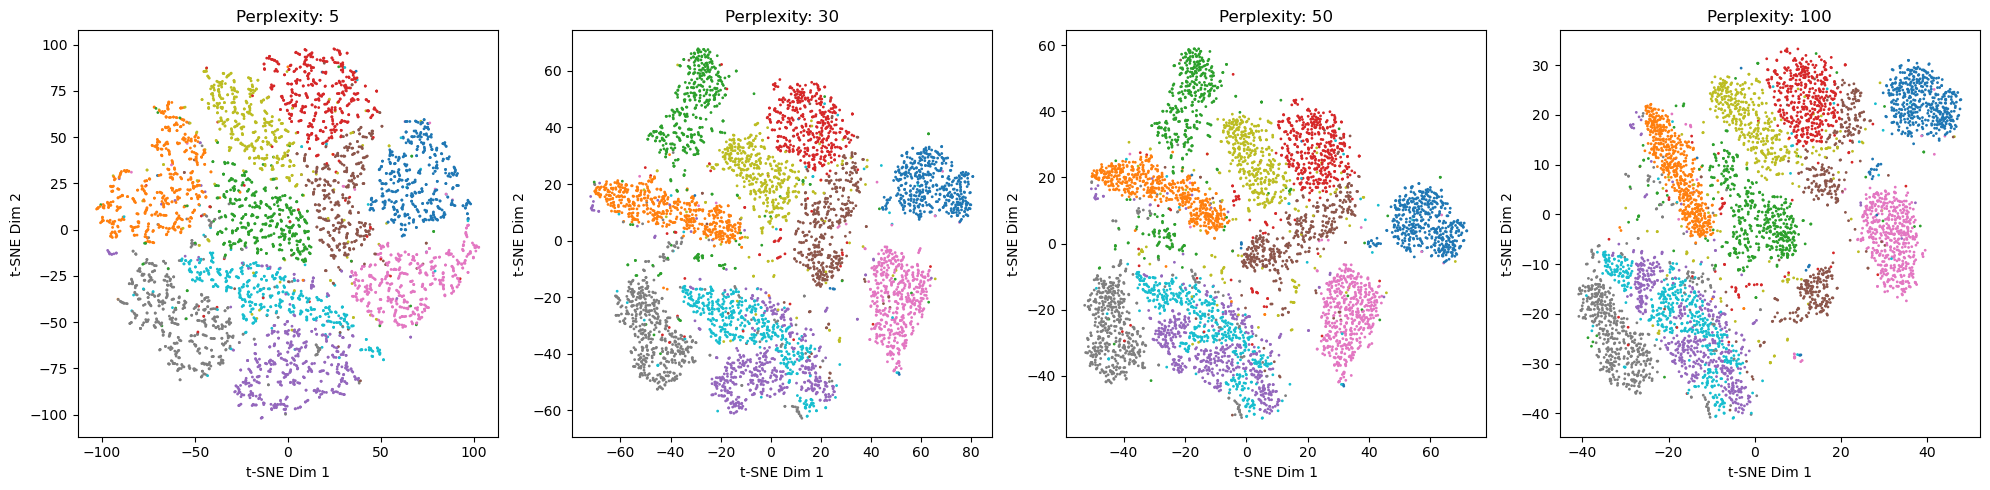

In [21]:

# Define perplexity values
perplexities = [5, 30, 50, 100]

# Initialize figure
fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 5))

# Apply t-SNE for each perplexity and plot
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_embedded = tsne.fit_transform(X_train_flat[:5000])  # Use a subset for efficiency
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train[:5000].astype(int), cmap='tab10', s=1)
    axes[i].set_title(f"Perplexity: {perplexity}")
    axes[i].set_xlabel("t-SNE Dim 1")
    axes[i].set_ylabel("t-SNE Dim 2")

# Add a color bar
#fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()